In [1]:
%matplotlib inline
from pyvista import set_plot_theme
set_plot_theme('document')


# Claudius


In [2]:
import sys, os
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=cpu"

# Importing gempy
import gempy as gp

# Aux imports
import numpy as np
import pandas as pn

# Loading data from repository:

With pandas we can do it directly from the web and with the right args
we can directly tidy the data in gempy style:




In [3]:
dfs = []
for letter in 'ABCD':
    dfs.append(pn.read_csv('https://raw.githubusercontent.com/Loop3D/ImplicitBenchmark/master/Claudius/' +
                           letter + 'Points.csv', sep=';',
                           names=['X', 'Y', 'Z', 'surface', 'cutoff'], header=0)[::5])
# Add fault:
dfs.append(pn.read_csv('https://raw.githubusercontent.com/Loop3D/ImplicitBenchmark/master/Claudius/Fault.csv',
                       names=['X', 'Y', 'Z', 'surface'], header=0, sep=';'))

surface_points = pn.concat(dfs, sort=True)
surface_points['surface'] =surface_points['surface'].astype('str')
# surface_points['surface'] = surface_points['surface'].astype('str')
surface_points.reset_index(inplace=True, drop=False)
surface_points.tail()

,index,X,Y,Z,cutoff,surface
4079,88,551099.250977,7.817652e+06,-10466.863281,NaN,Claudius_fault
4080,89,551160.807495,7.817503e+06,-10356.463867,NaN,Claudius_fault
4081,90,551131.898438,7.817659e+06,-10383.323242,NaN,Claudius_fault
4082,91,551164.412476,7.817654e+06,-10299.957031,NaN,Claudius_fault
4083,92,551197.192139,7.817647e+06,-10216.820312,NaN,Claudius_fault


In [4]:
surface_points.dtypes

index        int64
X          float64
Y          float64
Z          float64
cutoff     float64
surface     object
dtype: object

How many points are per surface




In [5]:
surface_points.groupby('surface').count()

,index,X,Y,Z,cutoff
surface,,,,,
0,1000,1000,1000,1000,1000
250,1000,1000,1000,1000,1000
330,991,991,991,991,991
60,1000,1000,1000,1000,1000
Claudius_fault,93,93,93,93,0


Now we do the same with the orientations:




In [6]:
dfs = []

for surf in ['0', '330']:
    o = pn.read_csv('https://raw.githubusercontent.com/Loop3D/ImplicitBenchmark/master/Claudius/Dips.csv', sep=';',
                    names=['X', 'Y', 'Z', 'G_x', 'G_y', 'G_z', '-'], header=1)

    # Orientation needs to belong to a surface. This is mainly to categorize to which series belong and to
    # use the same color
    o['surface'] = surf
    dfs.append(o)
orientations = pn.concat(dfs, sort=True)
orientations.reset_index(inplace=True, drop=False)

orientations.tail()

,index,-,G_x,G_y,G_z,X,Y,Z,surface
43,19,0.976692,0.187195,0.138165,-0.972558,550989.3105,7817210.527,-9782.967773,330
44,20,0.248187,-0.080561,-0.043063,-0.995819,550939.3105,7821227.309,-9958.425781,330
45,21,0.649480,-0.161328,0.075208,-0.984031,549276.8105,7820682.980,-9985.125977,330
46,22,0.050025,-0.012103,-0.153309,-0.988104,548976.8105,7820345.121,-9974.265625,330
47,23,0.759421,0.369490,-0.187053,-0.910213,549764.3105,7820457.738,-9901.208984,330


In [7]:
orientations.dtypes

index        int64
-          float64
G_x        float64
G_y        float64
G_z        float64
X          float64
Y          float64
Z          float64
surface     object
dtype: object

# Data initialization:

Suggested size of the axis-aligned modeling box: Origin: 548800 7816600
-8400 Maximum: 552500 7822000 -11010

Suggested resolution: 100m x 100m x -90m (grid size 38 x 55 x 30)




Number of voxels:



In [8]:
np.array([38, 55, 30]).prod()

62700

In [9]:
geo_model = gp.create_model('Claudius')
# Importing the data from csv files and settign extent and resolution
geo_model = gp.init_data(geo_model,
                         extent=[548800, 552500, 7816600, 7822000, -11010, -8400], resolution=[38, 55, 30],
                         surface_points_df=surface_points[::5], orientations_df=orientations, surface_name='surface',
                         add_basement=True)

Active grids: ['regular']


We are going to increase the smoothness (nugget) of the data to increase
the conditional number of the matrix:




In [10]:
geo_model.modify_surface_points(geo_model.surface_points.df.index, smooth=0.1).df.tail()

,X,Y,Z,X_r,Y_r,Z_r,surface,series,id,order_series,smooth
4060,551031.979248,7.816791e+06,-10920.000000,0.535138,0.268301,0.395686,Claudius_fault,Default series,5,1,0.1
4065,551117.123901,7.816600e+06,-10773.669922,0.543252,0.250100,0.409631,Claudius_fault,Default series,5,1,0.1
4070,551003.816162,7.817268e+06,-10920.000000,0.532454,0.313798,0.395686,Claudius_fault,Default series,5,1,0.1
4075,551036.303955,7.817559e+06,-10714.674805,0.535550,0.341503,0.415253,Claudius_fault,Default series,5,1,0.1
4080,551160.807495,7.817503e+06,-10356.463867,0.547415,0.336161,0.449390,Claudius_fault,Default series,5,1,0.1


Also the original poles are pointing downwards. We can change the
direction by calling the following:




In [11]:
geo_model.modify_orientations(geo_model.orientations.df.index, polarity=-1).df.tail()

,X,Y,Z,X_r,Y_r,Z_r,G_x,G_y,G_z,dip,azimuth,polarity,surface,series,id,order_series,smooth
43,550989.3105,7817210.527,-9782.967773,0.531072,0.308282,0.504043,-0.187194,-0.138164,0.972558,166.546239,53.569684,-1.0,330,Default series,4,1,0.01
44,550939.3105,7821227.309,-9958.425781,0.526307,0.691072,0.487322,0.080561,0.043063,0.995819,174.758819,241.873756,-1.0,330,Default series,4,1,0.01
45,549276.8105,7820682.980,-9985.125977,0.367875,0.639198,0.484777,0.161328,-0.075208,0.984031,169.746878,294.994025,-1.0,330,Default series,4,1,0.01
46,548976.8105,7820345.121,-9974.265625,0.339285,0.607001,0.485812,0.012103,0.153310,0.988104,171.153539,184.513861,-1.0,330,Default series,4,1,0.01
47,549764.3105,7820457.738,-9901.208984,0.414332,0.617733,0.492775,-0.369491,0.187053,0.910213,155.534803,116.850651,-1.0,330,Default series,4,1,0.01


We need an orientation per series/fault. The faults does not have
orientation so the easiest is to create an orientation from the surface
points availablle:




In [12]:
fault_idx = geo_model.surface_points.df.index[geo_model.surface_points.df['surface'] == 'Claudius_fault']
gp.set_orientation_from_surface_points(geo_model, fault_idx).df.tail()

D:\Hsintien_tsai\Anaconda3\envs\GempyEnve1208\lib\site-packages\gempy\core\data_modules\geometric_data.py:599: UserWarning: If pole_vector and orientation are passed pole_vector is used/
  warnings.warn('If pole_vector and orientation are passed pole_vector is used/')


,X,Y,Z,X_r,Y_r,Z_r,G_x,G_y,G_z,dip,azimuth,polarity,surface,series,id,order_series,smooth
44,550939.310500,7.821227e+06,-9958.425781,0.526307,0.691072,0.487322,0.080561,0.043063,0.995819,174.758819,241.873756,-1.0,330,Default series,4,1,0.01
45,549276.810500,7.820683e+06,-9985.125977,0.367875,0.639198,0.484777,0.161328,-0.075208,0.984031,169.746878,294.994025,-1.0,330,Default series,4,1,0.01
46,548976.810500,7.820345e+06,-9974.265625,0.339285,0.607001,0.485812,0.012103,0.153310,0.988104,171.153539,184.513861,-1.0,330,Default series,4,1,0.01
47,549764.310500,7.820458e+06,-9901.208984,0.414332,0.617733,0.492775,-0.369491,0.187053,0.910213,155.534803,116.850651,-1.0,330,Default series,4,1,0.01
48,551218.849348,7.817084e+06,-10341.638563,0.552946,0.296221,0.450803,-0.934574,-0.084591,0.345565,69.783691,264.828072,1.0,Claudius_fault,Default series,5,1,0.01


Now we can see how the data looks so far:




In [13]:
geo_model.surfaces

,surface,series,order_surfaces,color,id
0,0,Default series,1,#015482,1
1,60,Default series,2,#9f0052,2
2,250,Default series,3,#ffbe00,3
3,330,Default series,4,#728f02,4
4,Claudius_fault,Default series,5,#443988,5
5,basement,Basement,1,#ff3f20,6


D:\Hsintien_tsai\Anaconda3\envs\GempyEnve1208\lib\site-packages\gempy\plot\plot_api.py:261: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  p.fig.show()


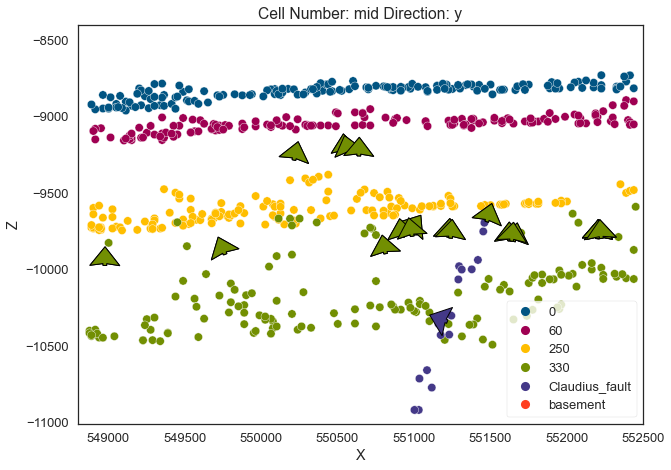

In [14]:
gp.plot_2d(geo_model, direction='y')

By default all surfaces belong to one unique series.




In [15]:
geo_model.surfaces

,surface,series,order_surfaces,color,id
0,0,Default series,1,#015482,1
1,60,Default series,2,#9f0052,2
2,250,Default series,3,#ffbe00,3
3,330,Default series,4,#728f02,4
4,Claudius_fault,Default series,5,#443988,5
5,basement,Basement,1,#ff3f20,6


We will need to separate with surface belong to each series:




In [16]:
stratigraphy = 'fixed'

In [17]:
if stratigraphy == 'original':
    gp.map_stack_to_surfaces(geo_model, {'Fault': 'Claudius_fault',
                                         'Default series': ('0', '60', '250', '330'),
                                         })
    # Ordering the events from younger to older:
    geo_model.reorder_series(['Fault', 'Default series', 'Basement'])


elif stratigraphy == 'fixed':
    gp.map_stack_to_surfaces(geo_model, {'Default series': ('0', '60', '250'),
                                         'Fault': 'Claudius_fault',
                                         'Uncomformity': '330',
                                         })
    # Ordering the events from younger to older:
    geo_model.reorder_series(['Default series', 'Fault', 'Uncomformity', 'Basement'])

So far we did not specify which series/faults are actula faults:




In [18]:
geo_model.set_is_fault('Fault')

Fault colors changed. If you do not like this behavior, set change_color to False.


,order_series,BottomRelation,isActive,isFault,isFinite
Default series,1,Erosion,True,False,False
Fault,2,Fault,True,True,False
Uncomformity,3,Erosion,True,False,False
Basement,4,Erosion,False,False,False


Ordering the events from younger to older:




geo_model.reorder_series(['Default series', 'Fault', 'Uncomformity', 'Basement'])



Check which series/faults are affected by other faults (rows offset
columns):




In [19]:
geo_model.faults.faults_relations_df

,Default series,Fault,Uncomformity,Basement
Default series,False,False,False,False
Fault,False,False,True,True
Uncomformity,False,False,False,False
Basement,False,False,False,False


Now we are good to go:




In [20]:
gp.set_interpolator(geo_model, theano_optimizer='fast_run',
                    compile_theano=True)

Setting kriging parameters to their default values.
Compiling theano function...
Level of Optimization:  fast_run
Device:  cpu
Precision:  float64
Number of faults:  1
Compilation Done!
Kriging values: 
                        values
range                 7047.13
$C_o$             1.18243e+06
drift equations  [3, 3, 3, 3]


In [21]:
gp.compute_model(geo_model)


Lithology ids 
  [5. 5. 5. ... 1. 1. 1.] 

D:\Hsintien_tsai\Anaconda3\envs\GempyEnve1208\lib\site-packages\gempy\plot\plot_api.py:261: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  p.fig.show()


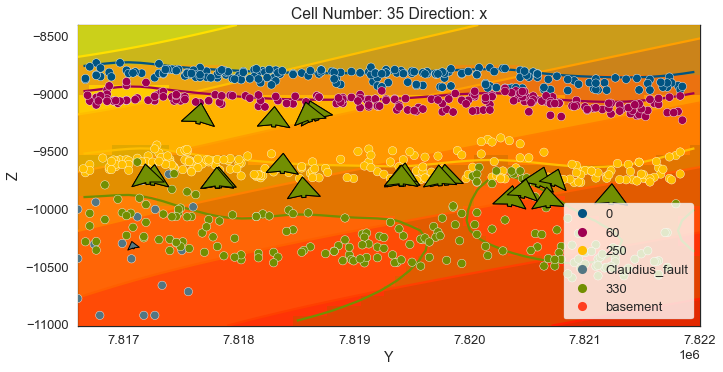

In [22]:
sect = [35]

gp.plot_2d(geo_model, cell_number=sect, series_n=1, show_scalar=True, direction='x')

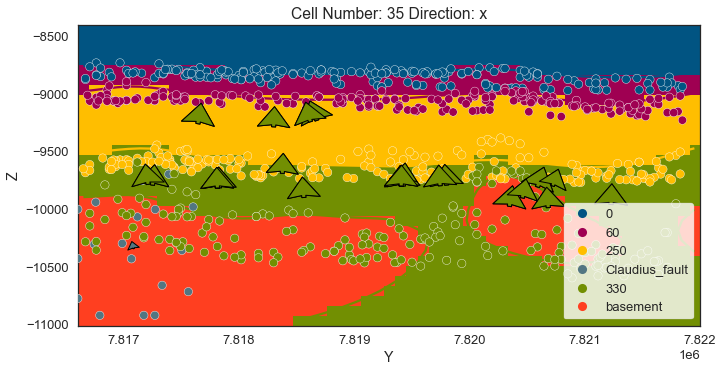

In [23]:
gp.plot_2d(geo_model, cell_number=sect, show_data=True, direction='x')

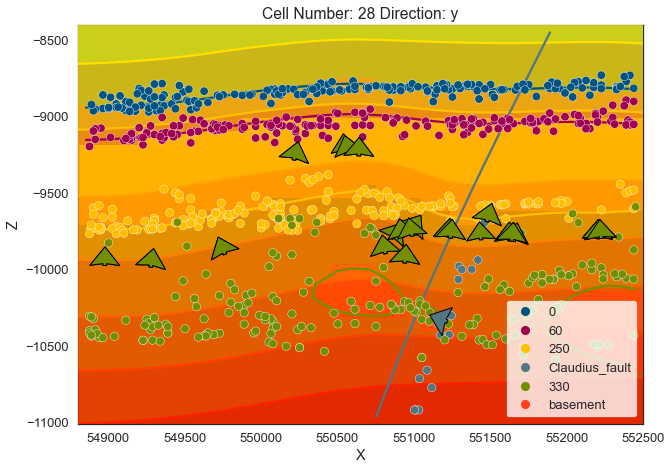

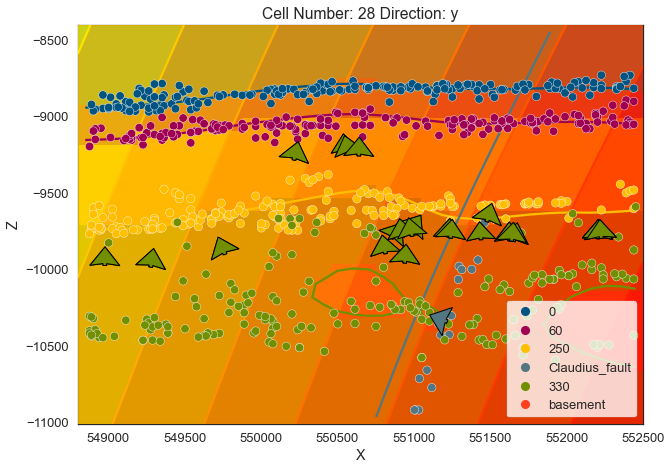

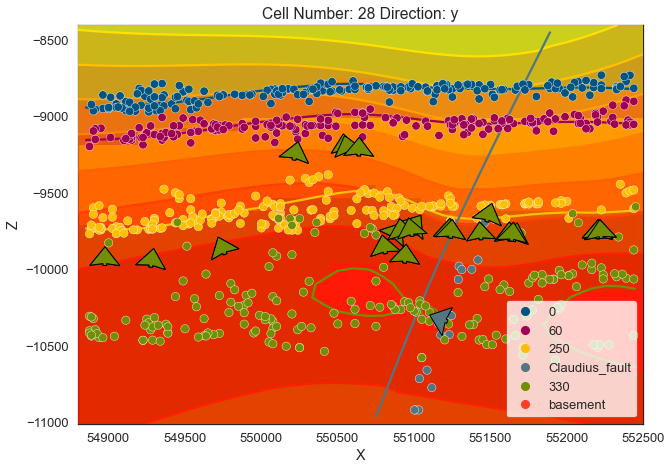

In [24]:
gp.plot_2d(geo_model, cell_number=[28], series_n=0, direction='y', show_scalar=True)
gp.plot_2d(geo_model, cell_number=[28], series_n=1, direction='y', show_scalar=True)
gp.plot_2d(geo_model, cell_number=[28], series_n=2, direction='y', show_scalar=True)

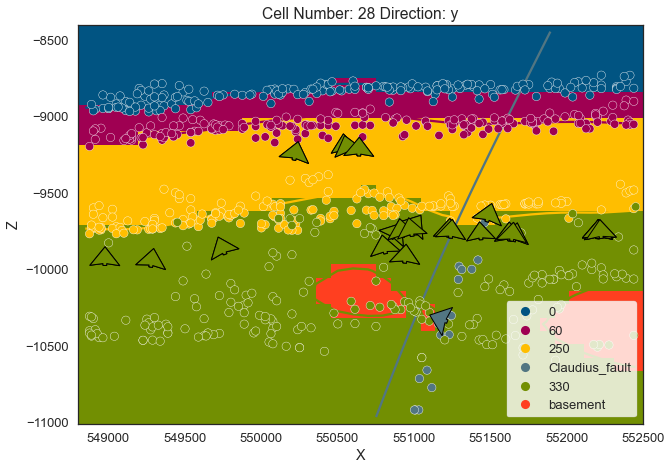

In [25]:
gp.plot_2d(geo_model, cell_number=[28], show_data=True, direction='y')

In [28]:
# sphinx_gallery_thumbnail_number = 8
gp.plot_3d(geo_model)

In [39]:
d=gp.plot_3d(geo_model)
d


# I want to use The .save function in  pyvista objects ,but I don't know how to call it? I have read the source code (https://github.com/cgre-aachen/gempy/blob/master/gempy/plot/vista.py) but I did not find the way to find the pyvista object.

In [87]:
from gempy.plot import vista
gv = vista.Vista(geo_model, plotter_type='basic', notebook=False, real_time=True)

AttributeError: module 'gempy.plot.vista' has no attribute 'Vista'